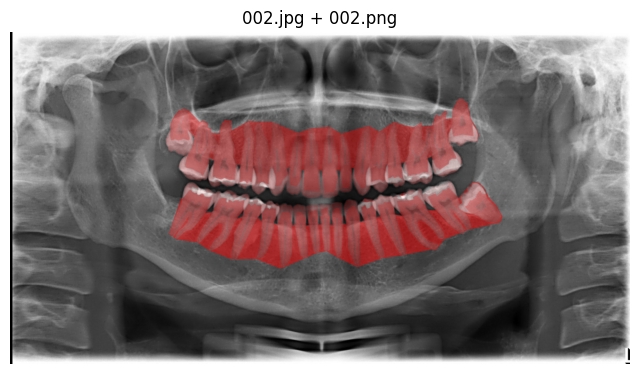

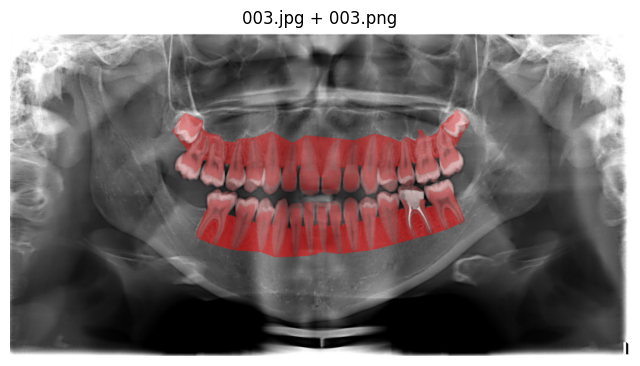

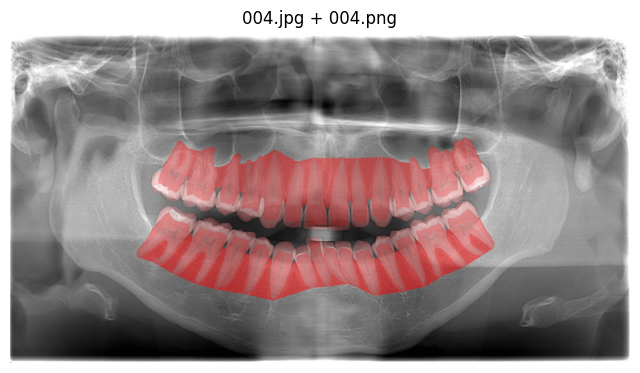

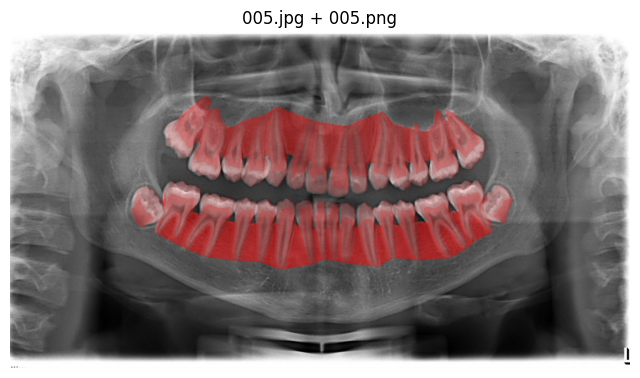

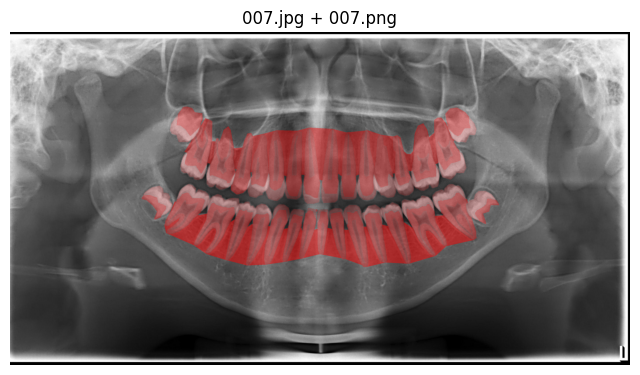

In [ ]:
import os
from pathlib import Path
from PIL import Image, ImageOps
import numpy as np



import matplotlib.pyplot as plt

# open image and mask, convert mask to alpha mask and overlay mask on coresponding image.
def overlay_mask_on_image(img_path, mask_path, color=(255, 0, 0), alpha=0.5):
    """
    Open image and mask, convert mask to an alpha mask and overlay a colored mask on the image.
    - img_path: path to RGB image (jpg/png)
    - mask_path: path to mask PNG (either binary or with alpha). Non-zero mask pixels are considered foreground.
    - color: RGB tuple for mask overlay color.
    - alpha: float in [0,1] controlling mask opacity.
    Returns a PIL RGBA image.
    """
    img = Image.open(img_path).convert("RGBA")
    mask = Image.open(mask_path).convert("L")  # convert mask to single channel (0-255)

    # If mask and image sizes differ, resize mask to image size
    if mask.size != img.size:
        mask = mask.resize(img.size, resample=Image.NEAREST)

    # Normalize mask to binary/alpha (0..255)
    mask_arr = np.array(mask)
    # If mask is already 0/255, keep it; otherwise threshold to create binary mask
    if mask_arr.max() > 1 and mask_arr.min() < 255:
        # keep as-is but ensure it's in 0..255
        alpha_mask = Image.fromarray(mask_arr.astype(np.uint8))
    else:
        # threshold small nonzero values
        bw = (mask_arr > 0).astype(np.uint8) * 255
        alpha_mask = Image.fromarray(bw.astype(np.uint8))

    # Create a solid color image and apply mask as its alpha channel scaled by requested alpha
    color_layer = Image.new("RGBA", img.size, color + (0,))
    # the mask determines transparency; scale by alpha
    alpha_channel = Image.eval(alpha_mask, lambda px: int(px * alpha))
    color_layer.putalpha(alpha_channel)

    # Composite color_layer over original image
    composed = Image.alpha_composite(img, color_layer)
    return composed

def find_and_show_overlays(images_dir, masks_dir, n_show=10, img_exts=(".jpg", ".jpeg", ".png")):
    images_dir = Path(images_dir)
    masks_dir = Path(masks_dir)
    if not images_dir.exists() or not masks_dir.exists():
        raise FileNotFoundError("Both images_dir and masks_dir must exist.")

    # Build a map of masks by stem for quick lookup
    mask_map = {p.stem: p for p in masks_dir.rglob("*.png")}

    displayed = 0
    for img_path in images_dir.rglob("*"):
        if img_path.suffix.lower() not in img_exts:
            continue
        stem = img_path.stem
        mask_path = mask_map.get(stem)
        if mask_path is None:
            # try same filename with .png extension in same folder as fallback
            alt = img_path.with_suffix(".png")
            if alt.exists():
                mask_path = alt
        if mask_path is None:
            continue

        composed = overlay_mask_on_image(img_path, mask_path, color=(255, 0, 0), alpha=0.5)
        plt.figure(figsize=(8, 8))
        plt.imshow(composed)
        plt.title(f"{img_path.name} + {mask_path.relative_to(masks_dir)}")
        plt.axis("off")
        plt.show()

        displayed += 1
        if displayed >= n_show:
            break

# Example usage: set your directories and run
images_dir = "E:/tooth_layer_ds_use/semantic/images"
masks_dir = "E:/tooth_layer_ds_use/semantic/labels"
find_and_show_overlays(images_dir, masks_dir, n_show=5)
